<h1><center>Predictive Maintenance in PySpark</center></h1>
<h1><center>Notebook II: Predictive Analytics</center></h1>

In this notebook, we show how to build predictive data models using **Apache Spark** and evaluate each model using different metrics. Types of predictive models in this notebook includes **Regression**, **Binary Classification**, and **Multi Classification** models. 

This notebook is divided into four main parts:
- [A. Import Data into PySpark Dataframes](#A.-Import-Data-into-PySpark-Dataframes)
- [B. Regression Analysis](#B.-Regression-Analysis)
- [C. Binary Classification](#C.-Binary-Classification)
- [D. Multi Classification](#D.-Multi-Classification)

This notebook is executable under [Python 2.7](https://www.python.org/download/releases/2.7/) and [Spark 2.3.2](https://spark.apache.org/releases/spark-release-2-3-2.html) versions.

In [2]:
from __future__ import division
import shutil
import os
import time
import operator
import re
import random
import numpy as np
import pandas as pd
from random import randint
from numpy import median
import matplotlib.pyplot as plt
import itertools
from pyspark.sql import SparkSession
from pyspark import SQLContext
from pyspark.sql.types import DoubleType, IntegerType
import pyspark.sql.functions as F
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression, DecisionTreeRegressor
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator, MulticlassClassificationEvaluator 
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import confusion_matrix

# set data path
path = 'CMAPSSData/'

<h2><center>A. Import Data into PySpark Dataframes</center></h2>
In this part, we read the dataframe generated in the previous notebook of this tutorial. We do also some visualizations of different features of train/test datasets.

# Steps

- [A.1 Folder Cleaning](#A.1-Folder-Cleaning)
- [A.2 Launch Spark Session](#A.2-Launch-Spark-Session)
- [A.3 Import *.parquet* Data Files into DF Objects](#A.3-Import-.parquet-Data-Files-into-DF-Objects)
- [A.4 Visualize Features](#A.4-Visualize-Features)

## A.1 Folder Cleaning
In this step, we delete both metastore_db directory and derby.log file, to enable the session to start with no corruption. Read the first notebook for more details in this regard.

In [ ]:
def clean_project_directory():
    '''
    this function delete both '/metastore_db' folder and '/derby.log' file before 
    initializing Apache Spark session
    '''

    # Folder Cleaning
    # delete metastore_db and derby.log (to avoid any inconsistant startout)
    print os.getcwd()

    if os.path.isdir(os.getcwd() + '/metastore_db'):
        shutil.rmtree(os.getcwd() + '/metastore_db', ignore_errors=True)

    if os.path.exists(os.getcwd() + '/derby.log'):
        os.remove(os.getcwd() + '/derby.log')

clean_project_directory()

## A.2 Launch Spark Session
After cleaning home directory, we create an instance of **Spark** module along with **sparkContext** object.

In [4]:
def create_spark_session(app_name, exe_memory):
    '''
    this function creates Spark session with application name and available memory to the session
    
    INPUTS:
    @app_name: name of Spark application
    @exe_memory: value of reserved memory to the session
    '''
    
    # Create the SparkSession
    return SparkSession.builder \
       .master("local") \
       .appName(app_name) \
       .config("spark.executor.memory", exe_memory) \
       .getOrCreate()

spark = create_spark_session('Predictive Maintenance2', '1gb')

# set spark Context object
sc = spark.sparkContext

## A.3 Import *.parquet* Data Files into DF Objects
The next step is to import the .parquet data files into PySpark Dataframe objects

In [5]:
%%time

# create SQLContext object to read Parquet files (support also JSON and JDBC data sources)
sqlContext = SQLContext(sc)

# Load data from .parquet files
train_df = sqlContext.read.parquet(os.getcwd() + '/' + path + 'train_FD001_preprocessed.parquet')
test_df = sqlContext.read.parquet(os.getcwd() + '/' + path + 'test_FD001_preprocessed.parquet')

CPU times: user 5.56 ms, sys: 0 ns, total: 5.56 ms
Wall time: 3.36 s


## A.4 Visualize Features
In this step, we visualize data features to be used in predictiion algorithms. The following cell contains the necessary functions to visualize data features.

# Steps

- [A.4.1 Visualization Functions](#A.4.1-Visualization-Functions)
- [A.4.2 Query PySpark Dataframes](#A.4.2-Query-PySpark-Dataframes)
- [A.4.3 Plot Data](#A.4.3-Plot-Data)

### A.4.1 Visualization Functions
In the below cell there are some necessary functions to be used in plotting sensor data in both train and test datasets.

In [6]:
%matplotlib inline

def sort_alphanumerically(s_list):
    '''
    this function sorts list of strings alphanumerically
    
    INPUTS:
    @s_list: list of strings
    
    OUTPUTS
    @s_list: list of strings sorted alphanumerically
    '''
    
    # convert numeric chars to numbers
    conv = lambda text: int(text) if text.isdigit() else text
    
    # set alphanumeric key to sort string begin with numbers
    alphanum_key = lambda key: [conv(c) for c in re.split('([0-9]+)', key)]
    
    # return sorted list using the alphanumeric key
    return sorted(s_list, key = alphanum_key)

def get_pandasdf_from_sparkdf(spark_df, view_name, query):
    '''
    this function queries Spark DF, and returns the result table as Pandas DF
    
    INPUTS:
    @spark_df: Spark DF to be queried
    @view_name: name of SQL view to be created from Spark DF
    @query: SQL query to be run on spark_df 
    '''
    
    spark_df.createOrReplaceTempView(view_name)
    return spark.sql(query).toPandas()

def plot_pandas_ts(df, time_feature, start_col_idx, rows, cols, figsize_H, figsize_V, save_fig, file_name):
    '''
    This function plots grid of features against one feature (usually time).
    
    INPUTS:
    @df: Pandas DF with features to be plotted
    @time_feature: column name of time feature shared by all other features (plotted as x axis)
    @start_col_idx: index of the first column to be plotted
    @rows: number of rows in the grid
    @cols: number of columns in the grid
    @figsize_H: figure size (horizontal)
    @figsize_V: figure size (vertical)   
    @save_fig: boolean variable to check whether the figure will be saved or not
    @file_name: name of figure file to be saved
    '''
    
    # set time_feature as df index
    df.set_index(time_feature) 
    
    # init plot
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(figsize_H, figsize_V))
    
    # loop over featureas and add corresponded sub-plots
    for i in range(0,rows):
        for j in range(0,cols):
            
            df[df.iloc[:,start_col_idx].name].plot(ax=axes[i,j]); 
            axes[i,j].set_title(df.iloc[:,start_col_idx].name, fontweight='bold')           
            axes[i,j].set_xlim([0,len(df)])
            start_col_idx+= 1
    
    plt.tight_layout()
    
    if save_fig:
        plt.savefig(file_name)

### A.4.2 Query PySpark Dataframes
As Spark does not support visualizations, we need to convert PySpark Dataframes into Pandas DFs. The best practical solution is to query PySpark Dataframe for the features we want to visualize, and convert the query outcome as Pandas Dataframe. 

In [7]:
# get list of features of interest
pca_features = sort_alphanumerically([s for s in set(train_df.columns) if (("PCA_" in s) and ("_norm" not in s) and ("_scaled" not in s)) ])

# create SQL query to retrieve pca_features from PySpark Dataframe
sqlQuery1 = "SELECT cycle, " + \
', '.join(pca_features) + \
" FROM df1 WHERE df1.id=3 ORDER BY df1.cycle DESC LIMIT 60 "

# submit the above SQL query to PySpark Dataframes and get corresponded outcomes as Pandas DFs
plotdata1 = get_pandasdf_from_sparkdf(train_df, "df1", sqlQuery1)
plotdata2 = get_pandasdf_from_sparkdf(test_df, "df1", sqlQuery1)

### A.4.3 Plot Data
After obtaining the Pandas DFs, we can visualize our data using plot_pandas_ts functions (listed above). The below visualizations display the last 60 runs of Engine #3 before failure (both train and test datasets) 

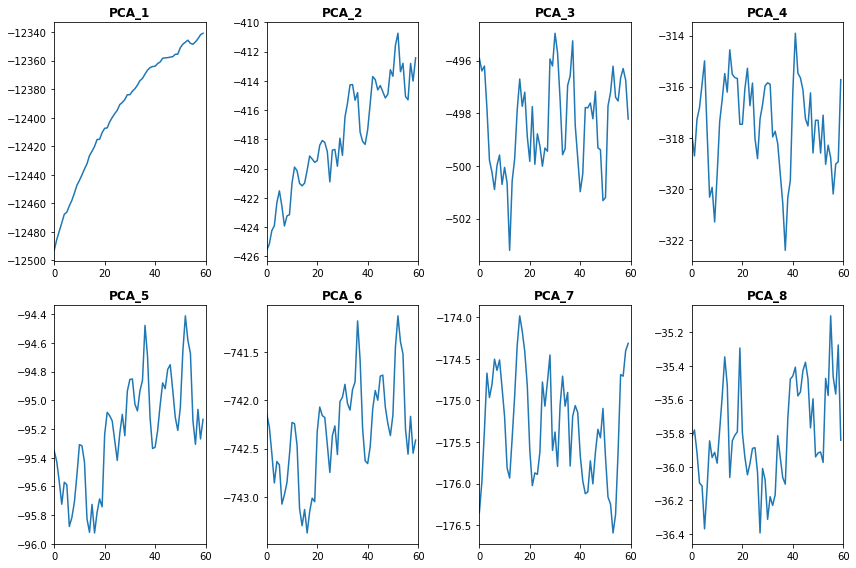

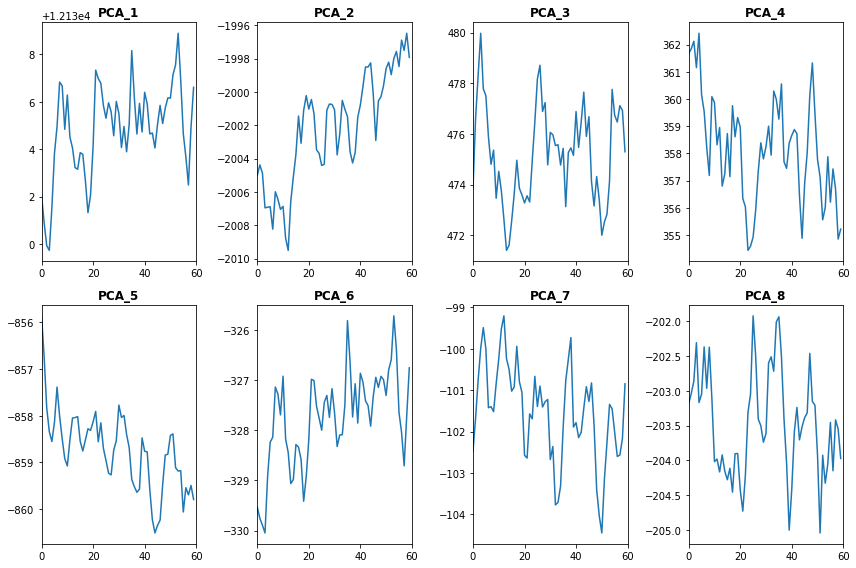

In [8]:
plot_pandas_ts(plotdata1, 'cycle', 1, 2, 4, 12, 8, False, '')
plot_pandas_ts(plotdata2, 'cycle', 1, 2, 4, 12, 8, False, '')

### Visualize Normalized PCAs
As anothe attempt, we will visualize normalized PCA features of Engine #3 in both train and test datasets. The below plots showing that for the train dataset, the first PCA features have clear trends over the last 60 runs before failure. While for the test dataset, the second and fifth PCAs have significant trends. 

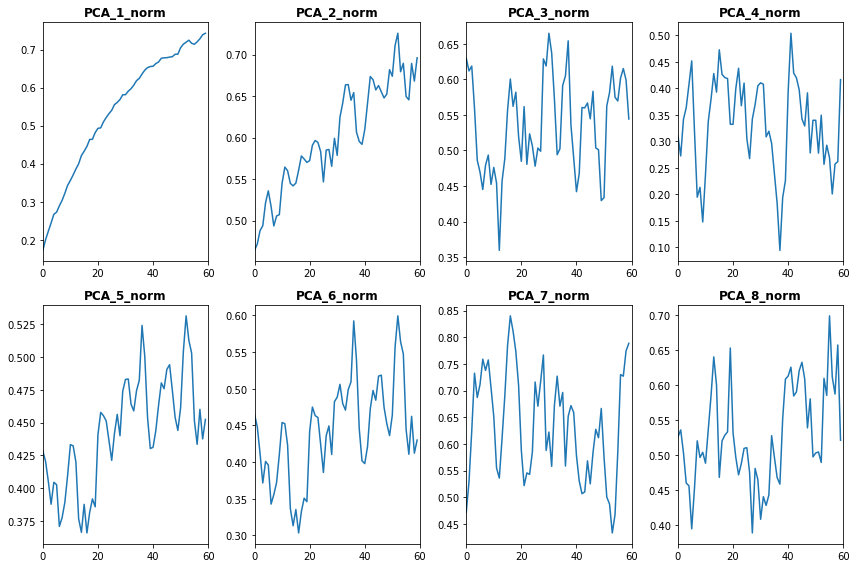

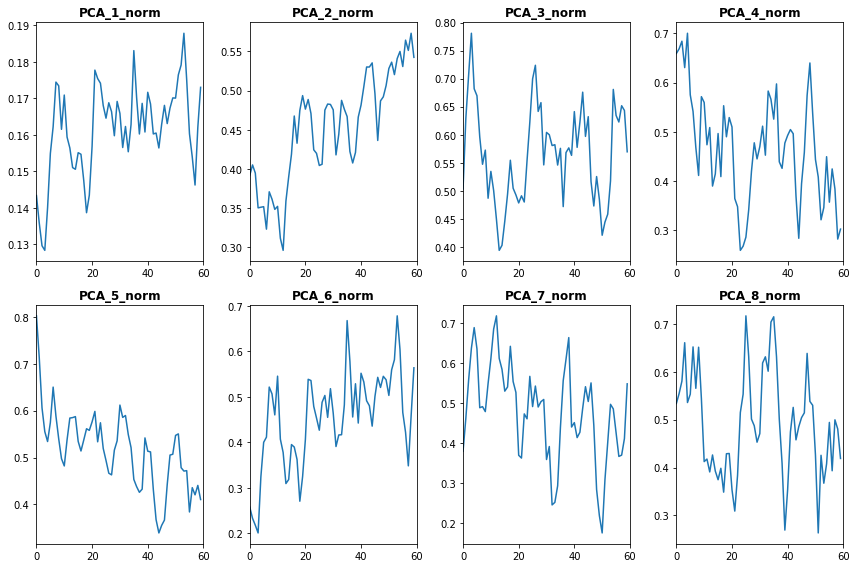

In [9]:
# get normalized PCA features
pca_norm_features = sort_alphanumerically([s for s in set(train_df.columns) if (("PCA_" in s) and ("_norm" in s)) ])

# create SQL query
sqlQuery2 = "SELECT cycle, " + \
', '.join(pca_norm_features) + \
" FROM df2 WHERE df2.id=3 ORDER BY df2.cycle DESC LIMIT 60 "

plotdata1 = get_pandasdf_from_sparkdf(train_df, "df2", sqlQuery2)
plotdata2 = get_pandasdf_from_sparkdf(test_df, "df2", sqlQuery2)

plot_pandas_ts(plotdata1, 'cycle', 1, 2, 4, 12, 8, False, '')
plot_pandas_ts(plotdata2, 'cycle', 1, 2, 4, 12, 8, False, '')

### Standardized PCA Visualization of Train Dataset (All Engines)
In this section, we visualize standardized PCA features of Train data of all engines.

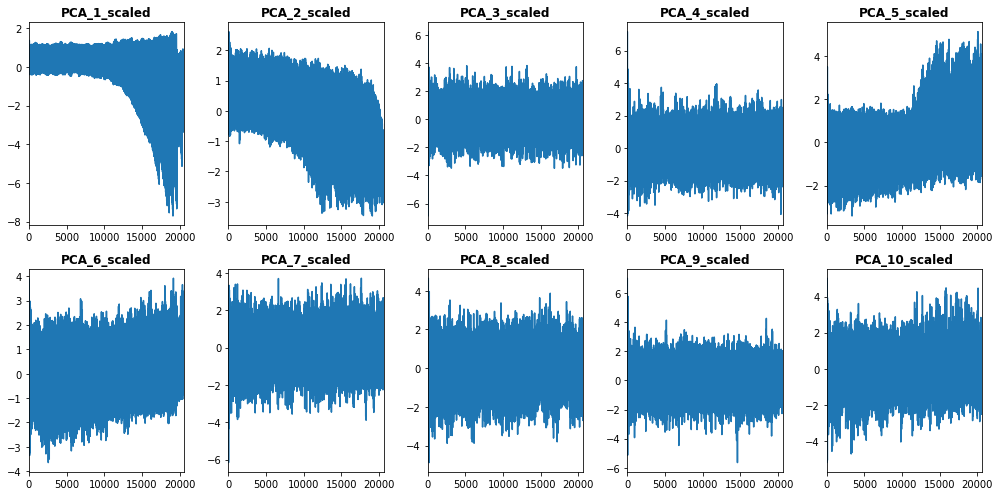

In [11]:
# get standardized PCA features
pca_scaled_features = sort_alphanumerically([s for s in set(train_df.columns) if (("PCA" in s) and ("scale" in s)) ])

# create query
sqlQuery3 = "SELECT cycle, " + \
', '.join(pca_scaled_features) + \
" FROM df3 ORDER BY df3.cycle"
sqlQuery2 = "SELECT cycle, " + \
', '.join(pca_norm_features) + \
" FROM df2 WHERE df2.id=3 ORDER BY df2.cycle DESC LIMIT 60 "

# get Pandas DF
plotdata1 = get_pandasdf_from_sparkdf(train_df, "df3", sqlQuery3)

# visualize data
plot_pandas_ts(plotdata1, 'cycle', 1, 2, 5, 14, 7, False, '')

### Standardized PCA Visualization of Test Dataset (All Engines)
In this section, we visualize standardized PCA features of test data of all engines.

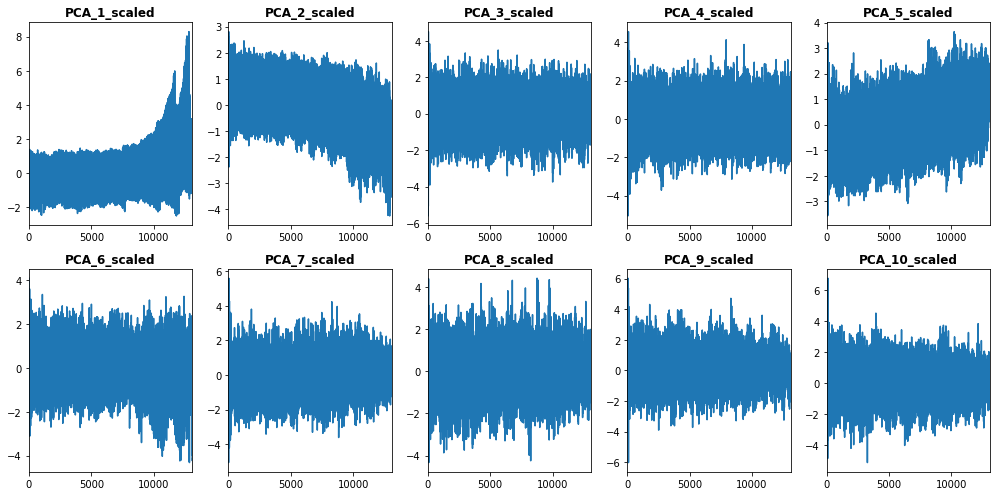

In [12]:
# get Pandas DF
plotdata2 = get_pandasdf_from_sparkdf(test_df, "df3", sqlQuery3)

# visualize data
plot_pandas_ts(plotdata2, 'cycle', 1, 2, 5, 14, 7, False, '')

<h2><center>B. Regression Analysis</center></h2>

In this part, we build regression models to predict engines' **Remaining Useful Life (RUL)**. The RUL of a machine is the number of successful runs the machine can do before an error occurs.

We firstly calculate correlations between RUL and other features to select the best correlated features for regression, and afterwards we  build our regression models. The regression algorithms in this notebook are Linear Regression, Generalized Linear Regression, and Decision Tree Regression.

# Steps

- [B.1 Calculate Correlations Between Features](#B.1-Calculate-Correlations-Between-Features)
- [B.2 Build Features Vector of Train Dataset](#B.2-Build-Features-Vector-of-Train-Dataset)
- [B.3 Linear Regression](#B.3-Linear-Regression)
- [B.4 Generalized Linear Regression](#B.4-Generalized-Linear-Regression)
- [B.5 Decision Tree Regression](#B.5-Decision-Tree-Regression)

## B.1 Calculate Correlations Between Features
The first step in regression analysis is to calculate correlations between the dependent variable (RUL) and independent variables.

In [13]:
%%time

def get_correlations(df, features):
    '''
    this function returns list of correlations of numerical features of PySpark Dataframe
    
    INPUTS:
    @df: PySpark Dataframe
    @features: list of columns' names to calculate correlations in between
    
    OUTPUTS:
    @sorted_corr_dict: list of @df feautres sorted by their correlations to the first feature
    '''
    
    # convert to vector column first
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols= features, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)

    # get correlation matrix
    r1 = Correlation.corr(df_vector, vector_col).head()

    # get list of Pearson correlations between first feature (RUL) and all other features
    corr_list = r1[0].toArray()[:1,:].tolist()[0]

    # set dictionary of features and correlations
    corr_dict = dict(zip(corr_list, input_features))

    # sort dictionary by Pearson correlations
    sorted_corr_dict = sorted(corr_dict.items(), key=operator.itemgetter(0))
    
    return sorted_corr_dict

# set index features
index_features = ["key", "id", "cycle", "label1", "label2", "rul"]

# set numerical features
numerical_features = list(set(train_df.columns) - set(index_features))

# set input features to numerical features plus "RUL"
input_features = ["rul"] + sort_alphanumerically(numerical_features)

# get Pearson correlations between RUL and other numerical features of both train and test datasets
train_ulr_corr = get_correlations(train_df, input_features)
test_ulr_corr = get_correlations(test_df, input_features)

# print top positive correlated features
print("Top Positive Correlated Features (Train):\n") 
for i in reversed(train_ulr_corr[-6:-1]):    
    print(i)

print("\nTop Positive Correlated Features (Test):\n") 
for i in reversed(test_ulr_corr[-6:-1]):    
    print(i)
    
# print top negative correlated features
print("\nTop Negative Correlated Features (Train):\n") 
for i in train_ulr_corr[0:5]:    
    print(i)
    
print("\nTop Negative Correlated Features (Test):\n") 
for i in test_ulr_corr[0:5]:    
    print(i)

Top Positive Correlated Features (Train):

(0.7891290976368206, 's12_rollingmean_4_scaled')
(0.7797179646508305, 's7_rollingmean_4_scaled')
(0.7743707880518276, 's12_rollingmean_4_norm')
(0.7733777137249406, 's7_rollingmean_4_norm')
(0.7117150656675688, 's12_rollingmean_4')

Top Positive Correlated Features (Test):

(0.54098279911739, 's12_rollingmean_4_norm')
(0.49366782512940416, 's7_rollingmean_4_norm')
(0.4751862708553446, 's12_rollingmean_4_scaled')
(0.4585230500478898, 's7_rollingmean_4_scaled')
(0.2875254965000236, 'PCA_2_scaled')

Top Negative Correlated Features (Train):

(-0.7888110654218343, 's4_rollingmean_4_scaled')
(-0.7757296788046874, 's4_rollingmean_4_norm')
(-0.7466390619110802, 's17_rollingmean_4_scaled')
(-0.7451601569134584, 's2_rollingmean_4_scaled')
(-0.7332185343637497, 's3_rollingmean_4_scaled')

Top Negative Correlated Features (Test):

(-0.5202779694027116, 'PCA_5_scaled')
(-0.5202779694027094, 'PCA_5_norm')
(-0.5202779694012791, 'PCA_5')
(-0.5094505130758384

## B.2 Build Features Vector of Train Dataset
After calculating correlations between features, we select the best 5 correlated features with RUL variable. Bases on the selected features, we build our training vector to be used in the regression algorithms.

In [14]:
# set list of engines
engines_list = [18, 30, 38, 12, 34]

# select features to be used into regression algorithms
train = train_df.select(train_df["s12_rollingmean_4_norm"],train_df["s7_rollingmean_4_scaled"],
                        train_df["s12_rollingmean_4_scaled"],train_df["s4_rollingmean_4_norm"], 
                        train_df["s4_rollingmean_4_scaled"],train_df["rul"])

# build train features vector
train_vector = train.rdd.map(lambda x: [x[5], Vectors.dense(x[0:5])]).toDF(['label','features'])

## B.3 Linear Regression
After building our features vector of train dataset, we train our linear regression model. We begin by defining the input parameters (lambda and elastic net). Then we build our model.

In [15]:
%%time

# set lambda param
lambda_param = [0]

# set elastic net param
elastic_net_param = [0]
    
# build and evaluate linear regression model
for l in lambda_param:
    for e in elastic_net_param:
        
        # init LR instance with parameters
        lr = LinearRegression(featuresCol = 'features', labelCol = 'label', maxIter=100, 
                              regParam=l, elasticNetParam=e)

        # fit linear regression model
        lr_model = lr.fit(train_vector)

        print "Lambda = ", str(l), " elastic net = ", str(e)
        
        ## get and print model coefficients
        print("LR Coefficients: " + str(lr_model.coefficients)) + "\n"        
        
        # set lists of evaluation metrics
        r_squared_list_lr = []
        mse_list_lr = []
        rmse_list_lr = []
        mae_list_lr = []  
        
        # loop over list of engines to validate the model of each engine
        for e in engines_list:                                                                
            print "Engine # ", e
            
            # select test features (with same features set as of train vector)
            test = test_df.filter(test_df.id == e).select(
                        test_df["s12_rollingmean_4_norm"],test_df["s7_rollingmean_4_scaled"],
                        test_df["s12_rollingmean_4_scaled"],test_df["s4_rollingmean_4_norm"],
                        test_df["s4_rollingmean_4_scaled"],test_df["rul"])
            
            # build test features vector
            test_vector = test.rdd.map(lambda x: [x[5], Vectors.dense(x[0:5])]).toDF(['label','features'])
            
            # get predictions
            pred = lr_model.transform(test_vector)

            ## evaluate regression model
            evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')
            
            # append evaluation metrics to evaluation lists
            r_squared_list_lr.append(evaluator.setMetricName('r2').evaluate(pred))
            mse_list_lr.append(evaluator.setMetricName('mse').evaluate(pred))
            rmse_list_lr.append(evaluator.setMetricName('rmse').evaluate(pred))
            mae_list_lr.append(evaluator.setMetricName('mae').evaluate(pred))
            
            # print evaluation metrics
            print "R-squared= ", evaluator.setMetricName('r2').evaluate(pred)
            print "MSE= ", evaluator.setMetricName('mse').evaluate(pred)
            print "RMSE= ", evaluator.setMetricName('rmse').evaluate(pred)
            print "MAE= ", evaluator.setMetricName('mae').evaluate(pred), "\n"

print "average R-Squared: ", sum(r_squared_list_lr) / float(len(r_squared_list_lr))
print "average MSE: ",sum(mse_list_lr) / float(len(mse_list_lr))
print "average RMSE: ",sum(rmse_list_lr) / float(len(rmse_list_lr))
print "average MAE: ",sum(mae_list_lr) / float(len(mae_list_lr))

Lambda =  0  elastic net =  0
LR Coefficients: [-39.79566889492461,16.17005402402594,29.786771197607724,-17.705185031876304,-16.697502235636133]

Engine #  18
R-squared=  0.224913463438
MSE=  1142.47755489
RMSE=  33.8005555412
MAE=  28.6923669523 

Engine #  30
R-squared=  0.392011106236
MSE=  1036.01307497
RMSE=  32.187156988
MAE=  25.8363031154 

Engine #  38
R-squared=  0.204478059613
MSE=  1035.76956638
RMSE=  32.1833740677
MAE=  26.4188140374 

Engine #  12
R-squared=  0.622945421593
MSE=  1479.56216567
RMSE=  38.4650772217
MAE=  30.8218331783 

Engine #  34
R-squared=  0.107491323456
MSE=  3064.87479525
RMSE=  55.3613113578
MAE=  48.5519118566 

average R-Squared:  0.310367874867
average MSE:  1551.73943143
average RMSE:  38.3994950353
average MAE:  32.064245828
CPU times: user 391 ms, sys: 95.7 ms, total: 487 ms
Wall time: 46.6 s


### Visualize Evaluations
In the below cell, we visualize evaluation metrics of the above Linear Regression model.

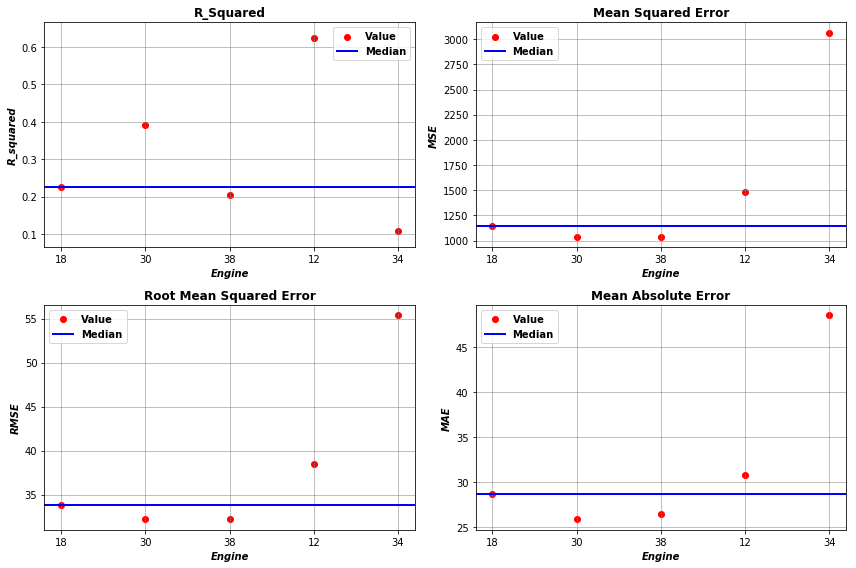

In [16]:
def plot_eval_metrics(X, Y, title, x_title, y_title, rows, cols, figsize_H, figsize_V, save_fig, file_name):
    '''
    this function plots an evaluation metric for a random set of engines
    
    INPUTS:
    @X: list of x axis ticks (representing engines)
    @Y: list of y axis ticks (representing eval matric)
    @start_col_idx: index of the first column to be plotted
    @rows: number of rows in the grid
    @cols: number of columns in the grid
    @figsize_H: figure size (horizontal)
    @figsize_V: figure size (vertical)
    @save_fig: boolean variable to check whether the figure will be saved or not
    @file_name: name of figure file to be saved
    '''
    # set list counter
    c = 0
    
    # init plot
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(figsize_H, figsize_V))
    
    # loop over featureas and add corresponded sub-plots
    for i in range(0,rows):
        for j in range(0,cols):
            
            axes[i,j].scatter([str(x) for x in X], Y[c], color = 'r', label="Value")
            axes[i,j].set_title(title[c], fontsize=12, fontweight='bold')  
            axes[i,j].set_xlabel(x_title, fontsize=10, fontweight='bold', style= "italic")
            axes[i,j].set_ylabel(y_title[c], fontsize=10, fontweight='bold', style= "italic")
            axes[i,j].grid(color='gray', linestyle='-', linewidth=.5)            
            axes[i,j].axhline(linewidth=2, y= median(Y[c]), color='b', label="Median")
            
            handles, labels = axes[i,j].get_legend_handles_labels()
            axes[i,j].legend(handles[::-1], labels[::-1], loc=0, prop={'weight':'bold'})
            
            c+= 1
    
    plt.tight_layout()
    
    if save_fig:
        plt.savefig(file_name)

# aggregate metrics lists into one list
metrics = [r_squared_list_lr, mse_list_lr, rmse_list_lr, mae_list_lr]

# set names of evaluation metrics
metrics_names = ["R_Squared", "Mean Squared Error", "Root Mean Squared Error", "Mean Absolute Error"]

# set plots titles
Y_titles = ["R_squared", "MSE", "RMSE", "MAE"]

plot_eval_metrics(engines_list, metrics, metrics_names, "Engine", Y_titles, 2, 2, 12, 8, False, "")

## B.4 Generalized Linear Regression
After building linear regression model, we will follow the same strategy to build generalized linear regression model, using the same train vector. Here we will test fitting our data using different values of Lambda parameter. 

In [17]:
%%time

# set lambda param
lambda_param = [0,.5, 1, 10, 30, 50]

# set lists of evaluation metrics (median over Lambda)
r_squared_median_glr = []
mse_median_glr = []
rmse_median_glr = []
mae_median_glr = []  

# fit GLR model using different Lambda params
for l in lambda_param:
    
    # init GLR instance with parameters
    glr_gauss = GeneralizedLinearRegression(featuresCol = 'features', labelCol = 'label', family="gaussian", 
                                            link="identity", maxIter=50, regParam=l)
 
    # fit GLR model
    glr_gauss_model = glr_gauss.fit(train_vector)

    # print Lambda value
    print "Lambda = ", str(l)
    
    ## get and print coefficients
    print("GLR Gaussian Coefficients: " + str(glr_gauss_model.coefficients)) + "\n"
   
    # set lists of evaluation metrics
    r_squared_list_glr = []
    mse_list_glr = []
    rmse_list_glr = []
    mae_list_glr = []  
    
    # loop over selected engines
    for e in engines_list: 
        
        # select test features (with same features set as of train vector)
        test = test_df.filter(test_df.id == e).select(
                        test_df["s12_rollingmean_4_norm"],test_df["s7_rollingmean_4_scaled"],
                        test_df["s12_rollingmean_4_scaled"],test_df["s4_rollingmean_4_norm"],
                        test_df["s4_rollingmean_4_scaled"],test_df["rul"])
            
        # build test features vector
        test_vector = test.rdd.map(lambda x: [x[5], Vectors.dense(x[0:5])]).toDF(['label','features'])

        # get predictions
        pred1 = glr_gauss_model.transform(test_vector)        

        ## evaluate model
        evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')
        
        r_squared_list_glr.append(evaluator.setMetricName('r2').evaluate(pred1))
        mse_list_glr.append(evaluator.setMetricName('mse').evaluate(pred1))
        rmse_list_glr.append(evaluator.setMetricName('rmse').evaluate(pred1))
        mae_list_glr.append(evaluator.setMetricName('mae').evaluate(pred1))                
        
    print "median R-Squared: ", median(r_squared_list_glr)
    print "median MSE: ",median(mse_list_glr) 
    print "median RMSE: ",median(rmse_list_glr) 
    print "median MAE: ",median(mae_list_glr), "\n"
    
    r_squared_median_glr.append(median(r_squared_list_glr))
    mse_median_glr.append(median(mse_list_glr))
    rmse_median_glr.append(median(rmse_list_glr))
    mae_median_glr.append(median(mae_list_glr))

Lambda =  0
GLR Gaussian Coefficients: [-39.79566889492461,16.17005402402594,29.786771197607724,-17.705185031876304,-16.697502235636133]

median R-Squared:  0.22491346343816354
median MSE:  1142.477554892147
median RMSE:  33.800555541176344
median MAE:  28.69236695227628 

Lambda =  0.5
GLR Gaussian Coefficients: [-13.161476252161197,16.237615430767555,23.29696811178323,-22.565055512861594,-15.81556606012641]

median R-Squared:  0.23534253755486567
median MSE:  1147.4958656026265
median RMSE:  33.874708347122734
median MAE:  28.548355364005907 

Lambda =  1
GLR Gaussian Coefficients: [0.3649680822770864,16.140087909383634,20.093816284507387,-26.513721136588366,-15.025472846635608]

median R-Squared:  0.24228237221250848
median MSE:  1228.4187879037795
median RMSE:  35.04880579854012
median MAE:  28.914470555968567 

Lambda =  10
GLR Gaussian Coefficients: [36.30759524336804,13.680303577724088,12.35514635862632,-41.928903792980556,-11.88188284939234]

median R-Squared:  0.22725599528795

### Visualize Evaluations
In the below cell, we visualize RMSE and MAE metrics values over different Lambda parameters.

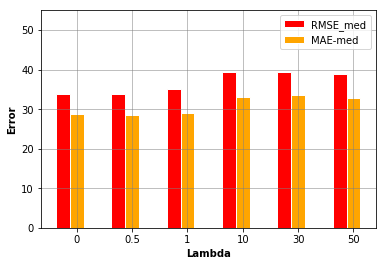

In [18]:
# set width of bar
barWidth = 0.25
 
# Set position of bar on X axis
r1 = np.arange(len(rmse_median_glr))
r2 = [x + barWidth for x in r1]
 
# create bar plot
plt.bar(r1, rmse_median_glr, color='red', width=barWidth, edgecolor='white', label='RMSE_med')
plt.bar(r2, mae_median_glr, color='orange', width=barWidth, edgecolor='white', label='MAE-med')
 
# add xticks on the middle of the group bars
plt.xlabel('Lambda', fontweight='bold')
plt.ylabel('Error', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(rmse_median_glr))], [str(x) for x in lambda_param])
plt.ylim([0,55])
plt.grid(color='gray', linestyle='-', linewidth=.5)   

# add legend 
plt.legend()

# show plot
plt.show()

## B.5 Decision Tree Regression
The third regression model in this notebook is the decision tree model. In the below cell, we build and evaluate decision tree model using different parameter settings.

In [19]:
%%time

# set tree max. depth
maxDepth = [5, 10]

# set tree max. number of bins
maxBins = [4, 8]

# set lists of evaluation metrics (median over maxDepth and maxBins params)
r_squared_median_dt = []
mse_median_dt = []
rmse_median_dt = []
mae_median_dt = []  

# build and evaluate decision tree regression model
for m1 in maxDepth:
    for m2 in maxBins:
        
        # init decision tree instance with parameters
        dt = DecisionTreeRegressor(featuresCol = 'features', labelCol = 'label', maxDepth=m1, maxBins=m2)

        # fit decision tree model
        dt_model = dt.fit(train_vector)
        
        # print parameters
        print "maxDepth = ", str(m1), " max Bins = ", str(m2), "\n"
        
        
        # set lists of evaluation metrics
        r_squared_list_dt = []
        mse_list_dt = []
        rmse_list_dt = []
        mae_list_dt = []  
        
        # loop over engines list
        for e in engines_list: 
            test = test_df.filter(test_df.id == e).select(
                        test_df["s12_rollingmean_4_norm"],test_df["s7_rollingmean_4_scaled"],
                        test_df["s12_rollingmean_4_scaled"],test_df["s4_rollingmean_4_norm"],
                        test_df["s4_rollingmean_4_scaled"],test_df["rul"])
            
            # build test features vector
            test_vector = test.rdd.map(lambda x: [x[5], Vectors.dense(x[0:5])]).toDF(['label','features'])
            
            # get predictions
            pred2 = dt_model.transform(test_vector)

            ## evaluate model
            evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')
            
            # append evaluations to evaluation lists
            r_squared_list_dt.append(evaluator.setMetricName('r2').evaluate(pred2))
            mse_list_dt.append(evaluator.setMetricName('mse').evaluate(pred2))
            rmse_list_dt.append(evaluator.setMetricName('rmse').evaluate(pred2))
            mae_list_dt.append(evaluator.setMetricName('mae').evaluate(pred2))                     
            
        print "median R-Squared: ", median(r_squared_list_dt)
        print "median MSE: ",median(mse_list_dt) 
        print "median RMSE: ",median(rmse_list_dt) 
        print "median MAE: ",median(mae_list_dt), '\n'
        
        # append evaluations' medians to median lists metrics
        r_squared_median_dt.append(median(r_squared_list_dt))
        mse_median_dt.append(median(mse_list_dt))
        rmse_median_dt.append(median(rmse_list_dt))
        mae_median_dt.append(median(mae_list_dt))

maxDepth =  5  max Bins =  4 

median R-Squared:  0.2109488013465084
median MSE:  2021.0993725649312
median RMSE:  44.956638804129156
median MAE:  34.39000675943137 

maxDepth =  5  max Bins =  8 

median R-Squared:  0.2587368658296212
median MSE:  1949.072147238039
median RMSE:  44.14829721787737
median MAE:  36.04739104979992 

maxDepth =  10  max Bins =  4 

median R-Squared:  0.2615910842192609
median MSE:  2361.48434721602
median RMSE:  48.595106206448605
median MAE:  39.69089356011583 

maxDepth =  10  max Bins =  8 

median R-Squared:  0.1925103581215516
median MSE:  2983.7077209127956
median RMSE:  54.623325795055685
median MAE:  44.38078595510133 

CPU times: user 640 ms, sys: 206 ms, total: 845 ms
Wall time: 1min 4s


<h2><center>C. Binary Classification</center></h2>
In this part, the goal is to classify engines' useful life into two zones: an **Alarm Zone** (1 to 15 runs before engine's failure), and a **Normal Zone** (longer than 15 runs before failure).

To achieve this goal, we build three binary classification models; namely: **Logistic Regression**, **Decision Tree**, and **Random Forest**.

To evaluate each model, we implement functions that calculate different evaluation metrics, such as **Accuracy**, **Macro/Micro Recall**, **Macro/Micro Precision**, and **F1**. 

# Steps

- [C.1 Build Features Vector of Train Dataset](#C.1-Build-Features-Vector-of-Train-Dataset)
- [C.2 Evaluation Functions](#C.2-Evaluation-Functions)
- [C.3 Logistic Regression](#C.3-Logistic-Regression)
- [C.4 Decision Tree](#C.4-Decision-Tree)
- [C.5 Random Forest](#C.5-Random-Forest)
- [C.6 Compare Classifiers](#C.6-Compare-Classifiers)

## C.1 Build Features Vector of Train Dataset
In below cell, we select 10 features to train our binary classifiers. These features were selected based on visualizations. You are free to select other subset of features and re-train the classifiers. The method of creating the train vector is the same as of regression part above.

In [20]:
# define list of engines
engines_list = [80,18,96,97,30,87,59,95,38,12]

# select features to be used into classification algorithms
train = train_df.select(train_df["s3_rollingmean_4_scaled"],train_df["s4_rollingmean_4_scaled"],
                        train_df["s7_rollingmean_4_scaled"],train_df["s12_rollingmean_4_scaled"],
                        train_df["s17_rollingmean_4_scaled"],train_df["PCA_1_scaled"],
                        train_df["PCA_2_scaled"],train_df["PCA_3_scaled"],train_df["PCA_4_scaled"],
                        train_df["PCA_5_scaled"],train_df["label1"])

# build train features vector
train_vector = train.rdd.map(lambda x: [x[10], Vectors.dense(x[0:10])]).toDF(['label','features'])

# change 'label' column data type to double
train_vector = train_vector.withColumn('label', train_vector['label'].cast(DoubleType()))

## C.2 Evaluation Functions
Now we add some functions to evaluate the each binary classifier. The functions below are using Python data strcutures mainly (e.g. Lists, Pandas DFs, NumPy Arrays).

In [21]:
def get_prediction_lists(prediction_df):
    '''
    this function returns true & predicted labels as Python lists, plus array of predictions, 
    using Spark prediction DF as input
    
    INPUTS:
    @prediction_df: Spark DF of classifier predictions 
    
    OUTPUTS:
    @l1: list of true labels
    @l2: list of predicted labels
    @m1: array of predictions
    '''
    
    l1 = map(int, get_col_as_list(prediction_df, "label"))
    l2 = map(int, get_col_as_list(prediction_df, "prediction"))
    m1 = get_col_as_nparray(prediction_df, "probability")
    
    return l1, l2, m1

def get_col_as_list(df, col_name):
    '''
    in this function, we convert a column in Spark DF to a Python list
    
    INPUTS:
    @df: Spark DF
    @col_name: name of the column 
    '''
    
    return df.select(col_name).rdd.flatMap(lambda x: x).collect()

def get_col_as_nparray(df, col_name):
    '''
    in this function, we convert a column in Spark DF to a Numpy array
    
    INPUTS:
    @df: Spark DF
    @col_name: name of the column 
    '''
    
    return np.array(df.select(col_name).collect())

def get_cm_metrics(matrix):
    '''
    this function returns the basic metrics extracted from confusion matrix
    
    INPUTS
    @matrix: m X m confusion matrix
    '''
    
    # get number of classes 
    d = matrix.shape[0]
    
    # set number of correct prediction
    correct_pred = 0
    
    # set variables for accuracy, macro/micro recall, macro/micro precision
    s1 = 0
    s2 = 0

    for i in range(0,d):
        correct_pred+= matrix[i,i]
        
        if np.sum(matrix[i,:])!= 0:
            s1+= matrix[i,i] / np.sum(matrix[i,:])
        
        if np.sum(matrix[:,i])!= 0:
            s2+= matrix[i,i] / np.sum(matrix[:,i])
    
    # compute metrics
    accuracy = correct_pred / np.sum(matrix)
    macro_p = s1 / d
    micro_p = correct_pred / np.sum(matrix)
    macro_r = s2 / d
    micro_r = micro_p
    macro_f1 = (2 * macro_p * macro_r) / (macro_p + macro_r)
    micro_f1 = (2 * micro_p * micro_r) / (micro_p + micro_r)
    
    return accuracy, macro_p, micro_p, macro_r, micro_r, macro_f1, micro_f1

## C.3 Logistic Regression
In this section, we train a logistic regression classifier using the above training vector. We use cross validation method for *k*=10 folds. 

In [22]:
%%time 

# init log regression object
lr = LogisticRegression(featuresCol='features', labelCol='label', family='binomial',  maxIter=10)

# create evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="label")

# init parameter grid for log rgression params
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0]) # Elastic Net Parameter (Ridge = 0)
             .build())

# create cross validation object
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10) 

# run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train_vector)

# set lists of evaluation metrics
accurany_list_lr = []
mac_p_list_lr = []
mac_r_list_lr = []
mac_F1_list_lr = []

# loop over engines list
for e in engines_list:     
    print "Engine # ", e
    test = test_df.filter(test_df.id == e).select(test_df["s3_rollingmean_4_scaled"],
                test_df["s4_rollingmean_4_scaled"],test_df["s7_rollingmean_4_scaled"],
                test_df["s12_rollingmean_4_scaled"],test_df["s17_rollingmean_4_scaled"],
                test_df["PCA_1_scaled"],test_df["PCA_2_scaled"],test_df["PCA_3_scaled"],
                test_df["PCA_4_scaled"],test_df["PCA_5_scaled"],test_df["label1"])

    # build test features vector
    test_vector = test.rdd.map(lambda x: [x[10], Vectors.dense(x[0:10])]).toDF(['label','features'])

    # Make predictions on test data 
    prediction_lr = cvModel.transform(test_vector)
    
    # get labels, predictions, and probabilities as python lists and nparrays
    labels, preds, probs = get_prediction_lists(prediction_lr)
    
    # get confusion matrix
    logreg_matrix = confusion_matrix(labels, preds)
    
    # print confusion matrix
    print 'Confusion Matrix:\n', logreg_matrix
    
    # get and print precision, recall, and F1 metrics
    accuracy, macro_p, _, macro_r, _, macro_f1, _ = get_cm_metrics(logreg_matrix)
    print "accuracy= ", round(accuracy,3)
    print "macro precision= ", round(macro_p,3)
    print "macro recall= ", round(macro_r,3)
    print "macro F1= ", round(macro_f1,3), '\n'

    # append evaluation metrics to lists
    accurany_list_lr.append(round(accuracy,3))
    mac_p_list_lr.append(round(macro_p,3))
    mac_r_list_lr.append(round(macro_r,3))
    mac_F1_list_lr.append(round(macro_f1,3))

Engine #  80
Confusion Matrix:
[[133]]
accuracy=  1.0
macro precision=  1.0
macro recall=  1.0
macro F1=  1.0 

Engine #  18
Confusion Matrix:
[[117   6]
 [  0  10]]
accuracy=  0.955
macro precision=  0.976
macro recall=  0.813
macro F1=  0.887 

Engine #  96
Confusion Matrix:
[[97]]
accuracy=  1.0
macro precision=  1.0
macro recall=  1.0
macro F1=  1.0 

Engine #  97
Confusion Matrix:
[[132   2]
 [  0   0]]
accuracy=  0.985
macro precision=  0.493
macro recall=  0.5
macro F1=  0.496 

Engine #  30
Confusion Matrix:
[[137   6]
 [  0   0]]
accuracy=  0.958
macro precision=  0.479
macro recall=  0.5
macro F1=  0.489 

Engine #  87
Confusion Matrix:
[[56]]
accuracy=  1.0
macro precision=  1.0
macro recall=  1.0
macro F1=  1.0 

Engine #  59
Confusion Matrix:
[[94]]
accuracy=  1.0
macro precision=  1.0
macro recall=  1.0
macro F1=  1.0 

Engine #  95
Confusion Matrix:
[[85  4]
 [ 0  0]]
accuracy=  0.955
macro precision=  0.478
macro recall=  0.5
macro F1=  0.489 

Engine #  38
Confusion Ma

## C.4 Decision Tree
In this section, we build decision tree classifier using same train/test subsets as of logistic regression. 
We use also cross validation method for *k*=10 folds.

In [23]:
%%time

# init decision tree object
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label')

# add empty parameter grid 
paramGrid = ParamGridBuilder()\
            .addGrid(dt.maxDepth, [4,5])\
            .build()
    
# create evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="label", metricName="areaUnderROC")

# create cross validatin object
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5) 

# run cross-validation, and choose the best set of parameters.
cvModel_dt = crossval.fit(train_vector)

# set lists of evaluation metrics
accurany_list_dt = []
mac_p_list_dt = []
mac_r_list_dt = []
mac_F1_list_dt = []

for e in engines_list:     
    print "Engine # ", e
    
    # select test features (with same features set as of train vector)
    test = test_df.filter(test_df.id == e).select(test_df["s3_rollingmean_4_scaled"],
                test_df["s4_rollingmean_4_scaled"],test_df["s7_rollingmean_4_scaled"],
                test_df["s12_rollingmean_4_scaled"],test_df["s17_rollingmean_4_scaled"],
                test_df["PCA_1_scaled"],test_df["PCA_2_scaled"],test_df["PCA_3_scaled"],
                test_df["PCA_4_scaled"],test_df["PCA_5_scaled"],test_df["label1"])

    # build test features vector
    test_vector = test.rdd.map(lambda x: [x[10], Vectors.dense(x[0:10])]).toDF(['label','features'])

    # Make predictions on test data 
    prediction_dt = cvModel_dt.transform(test_vector)
    
    # get labels, predictions, and probabilities as python lists and nparrays
    labels, preds, probs = get_prediction_lists(prediction_dt)
    
    # get confusion matrix
    dt_matrix = confusion_matrix(labels, preds)
    
    # print confusion matrix
    print 'Confusion Matrix:\n', dt_matrix
    
    # get and print precision, recall, and F1 metrics
    accuracy, macro_p, _, macro_r, _, macro_f1, _ = get_cm_metrics(dt_matrix)
    print "accuracy= ", round(accuracy,3)
    print "macro precision= ", round(macro_p,3)
    print "macro recall= ", round(macro_r,3)
    print "macro F1= ", round(macro_f1,3), '\n'
    
    # append evaluation metrics to lists
    accurany_list_dt.append(round(accuracy,3))
    mac_p_list_dt.append(round(macro_p,3))
    mac_r_list_dt.append(round(macro_r,3))
    mac_F1_list_dt.append(round(macro_f1,3))

Engine #  80
Confusion Matrix:
[[128   5]
 [  0   0]]
accuracy=  0.962
macro precision=  0.481
macro recall=  0.5
macro F1=  0.49 

Engine #  18
Confusion Matrix:
[[119   4]
 [  1   9]]
accuracy=  0.962
macro precision=  0.934
macro recall=  0.842
macro F1=  0.885 

Engine #  96
Confusion Matrix:
[[93  4]
 [ 0  0]]
accuracy=  0.959
macro precision=  0.479
macro recall=  0.5
macro F1=  0.489 

Engine #  97
Confusion Matrix:
[[117  17]
 [  0   0]]
accuracy=  0.873
macro precision=  0.437
macro recall=  0.5
macro F1=  0.466 

Engine #  30
Confusion Matrix:
[[135   8]
 [  0   0]]
accuracy=  0.944
macro precision=  0.472
macro recall=  0.5
macro F1=  0.486 

Engine #  87
Confusion Matrix:
[[55  1]
 [ 0  0]]
accuracy=  0.982
macro precision=  0.491
macro recall=  0.5
macro F1=  0.495 

Engine #  59
Confusion Matrix:
[[93  1]
 [ 0  0]]
accuracy=  0.989
macro precision=  0.495
macro recall=  0.5
macro F1=  0.497 

Engine #  95
Confusion Matrix:
[[84  5]
 [ 0  0]]
accuracy=  0.944
macro precisi

## C.5 Random Forest
The last classifier in this part is the Random Forest classifier. Below is the training and evaluation steps of Random Forest classifier. As we did in both Log. Regression and Decision Tree classifiers above, we apply cross validation method for *k*=10 folds.

In [24]:
%%time

# init random forest object
rf = RandomForestClassifier(featuresCol='features', labelCol='label')

# add empty parameter grid 
paramGrid = ParamGridBuilder().addGrid(rf.numTrees,[10,20]).build()
    
# create evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="label", metricName="areaUnderROC")

# create cross validatin object
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5) 

# run cross-validation, and choose the best set of parameters.
cvModel_rf = crossval.fit(train_vector)

# set lists of evaluation metrics
accurany_list_rf = []
mac_p_list_rf = []
mac_r_list_rf = []
mac_F1_list_rf = []

# loop over engines list
for e in engines_list:     
    print "Engine # ", e
    
    # filter test dataset over engine 'e'
    test = test_df.filter(test_df.id == e).select(test_df["s3_rollingmean_4_scaled"],
                test_df["s4_rollingmean_4_scaled"],test_df["s7_rollingmean_4_scaled"],
                test_df["s12_rollingmean_4_scaled"],test_df["s17_rollingmean_4_scaled"],
                test_df["PCA_1_scaled"],test_df["PCA_2_scaled"],test_df["PCA_3_scaled"],
                test_df["PCA_4_scaled"],test_df["PCA_5_scaled"],test_df["label1"])

    # build test features vector
    test_vector = test.rdd.map(lambda x: [x[10], Vectors.dense(x[0:10])]).toDF(['label','features'])

    # make predictions on test data
    prediction_rf = cvModel_rf.transform(test_vector)
    
    # get labels, predictions, and probabilities as python lists and nparrays
    labels, preds, probs = get_prediction_lists(prediction_rf)
    
    # get confusion matrix
    rf_matrix = confusion_matrix(labels, preds)
    
    # print confusion matrix
    print 'Confusion Matrix:\n', rf_matrix
    
    # get and print precision, recall, and F1 metrics
    accuracy, macro_p, micro_p, macro_r, _, macro_f1, micro_f1 = get_cm_metrics(rf_matrix)
    print "accuracy= ", round(accuracy,3)
    print "macro precision= ", round(macro_p,3)
    print "macro recall= ", round(macro_r,3)
    print "macro F1= ", round(macro_f1,3), '\n'
    
    # append evaluation metrics to lists
    accurany_list_rf.append(round(accuracy,3))
    mac_p_list_rf.append(round(macro_p,3))
    mac_r_list_rf.append(round(macro_r,3))
    mac_F1_list_rf.append(round(macro_f1,3))

Engine #  80
Confusion Matrix:
[[128   5]
 [  0   0]]
accuracy=  0.962
macro precision=  0.481
macro recall=  0.5
macro F1=  0.49 

Engine #  18
Confusion Matrix:
[[116   7]
 [  0  10]]
accuracy=  0.947
macro precision=  0.972
macro recall=  0.794
macro F1=  0.874 

Engine #  96
Confusion Matrix:
[[93  4]
 [ 0  0]]
accuracy=  0.959
macro precision=  0.479
macro recall=  0.5
macro F1=  0.489 

Engine #  97
Confusion Matrix:
[[120  14]
 [  0   0]]
accuracy=  0.896
macro precision=  0.448
macro recall=  0.5
macro F1=  0.472 

Engine #  30
Confusion Matrix:
[[134   9]
 [  0   0]]
accuracy=  0.937
macro precision=  0.469
macro recall=  0.5
macro F1=  0.484 

Engine #  87
Confusion Matrix:
[[55  1]
 [ 0  0]]
accuracy=  0.982
macro precision=  0.491
macro recall=  0.5
macro F1=  0.495 

Engine #  59
Confusion Matrix:
[[93  1]
 [ 0  0]]
accuracy=  0.989
macro precision=  0.495
macro recall=  0.5
macro F1=  0.497 

Engine #  95
Confusion Matrix:
[[83  6]
 [ 0  0]]
accuracy=  0.933
macro precisi

## C.6 Compare Classifiers
In this section, we visually compare evaluation metrics of the three binary classifiers. The below figure shows that Logistic Regression performs better than both Decision Tree and Random Forest classifiers.

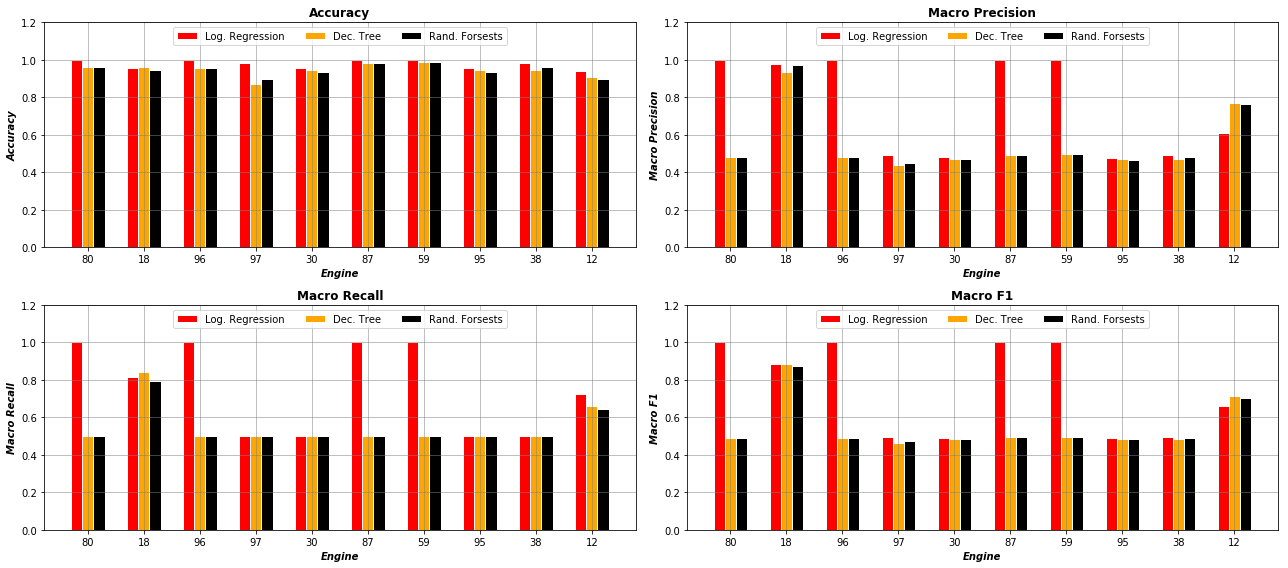

In [25]:
LR_eval = [accurany_list_lr, mac_p_list_lr, mac_r_list_lr,  mac_F1_list_lr]
DT_eval = [accurany_list_dt, mac_p_list_dt, mac_r_list_dt, mac_F1_list_dt]
RF_eval = [accurany_list_rf, mac_p_list_rf, mac_r_list_rf, mac_F1_list_rf]
metrics_names = ["Accuracy", "Macro Precision", "Macro Recall",  "Macro F1"]
Y_titles = metrics_names

def plot_eval_metrics_binary_classification(X, LR_eval, DT_eval, RF_eval, title, x_title, y_title, 
                                            rows, cols, figsize_H, figsize_V, save_fig, file_name):
    
    '''
    this function plots an evaluation metric for a random set of engines
    
    INPUTS:
    @X: list of x axis ticks (representing engines)
    @Y: list of y axis ticks (representing eval matric)
    @start_col_idx: index of the first column to be plotted
    @rows: number of rows in the grid
    @cols: number of columns in the grid
    @figsize_H: figure size (horizontal)
    @figsize_V: figure size (vertical)
    @save_fig: boolean variable to check whether the figure will be saved or not
    @file_name: name of figure file to be saved
    '''
    # set list counter
    c = 0
    
    # set width of bar
    barWidth = 0.2
    
    # init plot
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(figsize_H, figsize_V))
    
    # set positions of categories columns on X axis 
    r2 = [str(x) for x in X]
    r1 = [x - barWidth for x in np.arange(len(X))]
    r3 = [x + barWidth for x in np.arange(len(X))] 

    # loop over featureas and add corresponded sub-plots
    for i in range(0,rows):
        for j in range(0,cols):
            
            #axes[i,j].scatter([str(x) for x in X], Y[c], color = 'r', label="Value")
            axes[i,j].bar(r1, LR_eval[c], color='red', width=barWidth, edgecolor='white', label='Log. Regression')
            axes[i,j].bar(r2, DT_eval[c], color='orange', width=barWidth, edgecolor='white', label='Dec. Tree')
            axes[i,j].bar(r3, RF_eval[c], color='black', width=barWidth, edgecolor='white', label='Rand. Forsests')
            axes[i,j].set_title(title[c], fontsize=12, fontweight='bold')  
            axes[i,j].set_xlabel(x_title, fontsize=10, fontweight='bold', style= "italic")
            axes[i,j].set_ylabel(y_title[c], fontsize=10, fontweight='bold', style= "italic")
            axes[i,j].set_ylim([0,1.2])    
            axes[i,j].grid(color='gray', linestyle='-', linewidth=.5)                                                        
            axes[i,j].legend(ncol=3, loc=9)
            
            c+= 1
    
    plt.tight_layout()
    
    if save_fig:
        plt.savefig(file_name)
        
plot_eval_metrics_binary_classification(engines_list, LR_eval, DT_eval, RF_eval, 
                                        metrics_names, "Engine", Y_titles, 2, 2, 18, 8, False, '') 

<h2><center>D. Multi Classification</center></h2>
In the last part of this notebook, we aim to distinguish three time zones of engine's life. These time zones are **Alarm Zone** (1 to 15 runs before engine's failure), **Warning Zone** (16 to 30 runs before engine's failure), and **Normal Zone** (longer than 30 runs before failure).

To achieve this goal, we train three multi classifiers; namely **Logistic Regression**, **Decision Tree**, and **Multilayer Perceptron**.

To evaluate each classifier, we use the same evaluation functions above. Accordingly, the same evaluation metrics are calculated (**Accuracy**, **Macro/Micro Recall**, **Macro/Micro Precision**, and **F1**). 

# Steps

- [D.1 Build Features Vector of Train Dataset](#D.1-Build-Features-Vector-of-Train-Dataset)
- [D.2 Logistic Regression](#D.2-Logistic-Regression)
- [D.3 Decision Tree](#D.3-Decision-Tree)
- [D.4 Multilayer Perceptron](#D.4-Multilayer-Perceptron)
- [D.5 Compare Classifiers](#D.5-Compare-Classifiers)

## D.1 Build Features Vector of Train Dataset
In below cell, the same subset of features used in training above binary classifiers will be used here. As for the engines list, we select the first 10 engines, as this is the subset of engines support three-class useful life.

In [26]:
# define list of engines
engines_list = range (1,11)

# select features to be used into regression algorithms
train = train_df.select(train_df["s3_rollingmean_4_scaled"],train_df["s4_rollingmean_4_scaled"],
                        train_df["s7_rollingmean_4_scaled"],train_df["s12_rollingmean_4_scaled"],
                        train_df["s17_rollingmean_4_scaled"],train_df["PCA_1_scaled"],
                        train_df["PCA_2_scaled"],train_df["PCA_3_scaled"],train_df["PCA_4_scaled"],
                        train_df["PCA_5_scaled"],train_df["label2"])

# build train features vector
train_vector = train.rdd.map(lambda x: [x[10], Vectors.dense(x[0:10])]).toDF(['label','features'])

# change 'label' column data type to double
train_vector = train_vector.withColumn('label', train_vector['label'].cast(DoubleType()))

## D.2 Logistic Regression
In this section, we begin multi-classification by building Logistic Regression multi-classifier. We use cross validation method of 5 folds and 100 iterations.

In [27]:
%%time

# init log regression instance
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=100)

# create evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="label")

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0]) # Elastic Net Parameter (Ridge = 0)
             .build())

# create cross validatin object
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5) 

# set lists of evaluation metrics
accurany_list_mclr = []
mac_p_list_mclr = []
mac_r_list_mclr = []
mac_F1_list_mclr = []
    
# run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train_vector)

# loop over engines list
for e in engines_list:        
    print "Engine # ", e
    
    # filter test dataset over engine 'e'
    test = test_df.filter(test_df.id == e).select(test_df["s3_rollingmean_4_scaled"],
            test_df["s4_rollingmean_4_scaled"],test_df["s7_rollingmean_4_scaled"],
            test_df["s12_rollingmean_4_scaled"],test_df["s17_rollingmean_4_scaled"],
            test_df["PCA_1_scaled"],test_df["PCA_2_scaled"],test_df["PCA_3_scaled"],
            test_df["PCA_4_scaled"],test_df["PCA_5_scaled"],test_df["label2"])

    # build test features vector
    test_vector = test.rdd.map(lambda x: [x[10], Vectors.dense(x[0:10])]).toDF(['label','features'])

    # make predictions on test data
    prediction_mul_lr = cvModel.transform(test_vector)

    # get labels, predictions, and probabilities as python lists and nparrays
    labels = map(int, get_col_as_list(prediction_mul_lr, "label"))
    preds = map(int, get_col_as_list(prediction_mul_lr, "prediction"))
    probs = get_col_as_nparray(prediction_mul_lr, "probability")

    # get confusion matrix
    logreg_matrix = confusion_matrix(labels, preds)

    # print confusion matrix
    print 'Confusion Matrix:\n', logreg_matrix

    # get and print precision, recall, and F1 metrics
    accuracy, macro_p, _, macro_r, _, macro_f1, _ = get_cm_metrics(logreg_matrix)
    print "accuracy= ", round(accuracy,3)
    print "macro precision= ", round(macro_p,3)
    print "macro recall= ", round(macro_r,3)
    print "micro F1= ", round(macro_f1,3), "\n"

    # append evaluation metrics to lists
    accurany_list_mclr.append(round(accuracy,3))
    mac_p_list_mclr.append(round(macro_p,3))
    mac_r_list_mclr.append(round(macro_r,3))
    mac_F1_list_mclr.append(round(macro_f1,3))

Engine #  1
Confusion Matrix:
[[ 7  0  0]
 [15  0  0]
 [ 9  0  0]]
accuracy=  0.226
macro precision=  0.333
macro recall=  0.075
micro F1=  0.123 

Engine #  2
Confusion Matrix:
[[26  0  0]
 [15  0  0]
 [ 8  0  0]]
accuracy=  0.531
macro precision=  0.333
macro recall=  0.177
micro F1=  0.231 

Engine #  3
Confusion Matrix:
[[103   0   0]
 [ 15   0   0]
 [  3   1   4]]
accuracy=  0.849
macro precision=  0.5
macro recall=  0.617
micro F1=  0.552 

Engine #  4
Confusion Matrix:
[[83  0  0]
 [15  0  0]
 [ 8  0  0]]
accuracy=  0.783
macro precision=  0.333
macro recall=  0.261
micro F1=  0.293 

Engine #  5
Confusion Matrix:
[[76  0  0]
 [15  0  0]
 [ 6  0  1]]
accuracy=  0.786
macro precision=  0.381
macro recall=  0.595
micro F1=  0.464 

Engine #  6
Confusion Matrix:
[[84  0  0]
 [15  0  0]
 [ 6  0  0]]
accuracy=  0.8
macro precision=  0.333
macro recall=  0.267
micro F1=  0.296 

Engine #  7
Confusion Matrix:
[[139   0   0]
 [ 14   1   0]
 [  6   0   0]]
accuracy=  0.875
macro precisio

## D.3 Decision Tree
In this section, we build multi-class decision tree classifier. We use cross validation method of 10 folds.

In [28]:
%%time

# init decision tree classifier
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label')

# create evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")

# create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [4, 8]) # max depth parameter
             .addGrid(dt.maxBins, [2,4,6]) # max bins Parameter 
             .build())

# create cross validatin object
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10) 

# set lists of evaluation metrics
accurany_list_mcdt = []
mac_p_list_mcdt = []
mac_r_list_mcdt = []
mac_F1_list_mcdt = []
    
# run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train_vector)

# loop over engines
for e in engines_list:    
    
    print "Engine # ", e
    
    # filter test dataset over engine 'e'
    test = test_df.filter(test_df.id == e).select(test_df["s3_rollingmean_4_scaled"],
            test_df["s4_rollingmean_4_scaled"],test_df["s7_rollingmean_4_scaled"],
            test_df["s12_rollingmean_4_scaled"],test_df["s17_rollingmean_4_scaled"],
            test_df["PCA_1_scaled"],test_df["PCA_2_scaled"],test_df["PCA_3_scaled"],
            test_df["PCA_4_scaled"],test_df["PCA_5_scaled"],test_df["label2"])

    # build test features vector
    test_vector = test.rdd.map(lambda x: [x[10], Vectors.dense(x[0:10])]).toDF(['label','features'])

    # make predictions on test data
    prediction_mcdt = cvModel.transform(test_vector)

    # get labels, predictions, and probabilities as python lists and nparrays
    labels = map(int, get_col_as_list(prediction_mcdt, "label"))
    preds = map(int, get_col_as_list(prediction_mcdt, "prediction"))
    probs = get_col_as_nparray(prediction_mcdt, "probability")

    # get confusion matrix
    mcdt_matrix = confusion_matrix(labels, preds)

    # print confusion matrix
    print 'Confusion Matrix:\n', mcdt_matrix
    
    # get and print precision, recall, and F1 metrics
    accuracy, macro_p, _, macro_r, _, macro_f1, _ = get_cm_metrics(mcdt_matrix)
    print "accuracy= ", round(accuracy,3)
    print "macro precision= ", round(macro_p,3)
    print "macro recall= ", round(macro_r,3)
    print "micro F1= ", round(macro_f1,3), "\n"

    # append evaluation metrics to lists
    accurany_list_mcdt.append(round(accuracy,3))
    mac_p_list_mcdt.append(round(macro_p,3))
    mac_r_list_mcdt.append(round(macro_r,3))
    mac_F1_list_mcdt.append(round(macro_f1,3))

Engine #  1
Confusion Matrix:
[[ 5  2  0]
 [14  1  0]
 [ 9  0  0]]
accuracy=  0.194
macro precision=  0.26
macro recall=  0.171
micro F1=  0.206 

Engine #  2
Confusion Matrix:
[[24  2  0]
 [15  0  0]
 [ 8  0  0]]
accuracy=  0.49
macro precision=  0.308
macro recall=  0.17
micro F1=  0.219 

Engine #  3
Confusion Matrix:
[[103   0   0]
 [ 13   2   0]
 [  1   6   1]]
accuracy=  0.841
macro precision=  0.419
macro recall=  0.71
micro F1=  0.527 

Engine #  4
Confusion Matrix:
[[82  1  0]
 [13  2  0]
 [ 7  1  0]]
accuracy=  0.792
macro precision=  0.374
macro recall=  0.435
micro F1=  0.402 

Engine #  5
Confusion Matrix:
[[75  1  0]
 [14  1  0]
 [ 6  1  0]]
accuracy=  0.776
macro precision=  0.351
macro recall=  0.374
micro F1=  0.362 

Engine #  6
Confusion Matrix:
[[82  2  0]
 [10  5  0]
 [ 6  0  0]]
accuracy=  0.829
macro precision=  0.437
macro recall=  0.517
micro F1=  0.473 

Engine #  7
Confusion Matrix:
[[124  15   0]
 [  7   6   2]
 [  1   5   0]]
accuracy=  0.813
macro precisio

## D.4 Multilayer Perceptron
The last classifier in this part is the multilayer perceptron. In the below cell, we create ML Perceptron classifier and run it over our train data vector. The classifier is validated over a cross validation technique of 10 folds.

In [29]:
%%time

# init multilayer perceptron object
mcpc = MultilayerPerceptronClassifier(featuresCol='features', labelCol='label', 
                                      maxIter= 100, layers=[10, 11, 10, 3])

# create evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")

# create ParamGrid for cross validation
paramGrid = ParamGridBuilder().build()

# create cross validatin object
crossval = CrossValidator(estimator=mcpc,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10) 

# set lists of evaluation metrics
accurany_list_mcpc = []
mac_p_list_mcpc = []
mac_r_list_mcpc = []
mac_F1_list_mcpc = []
    
# run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train_vector)

# loop ove engines
for e in engines_list:    
    
    print "Engine # ", e
    
    # filter test dataset over engine 'e'
    test = test_df.filter(test_df.id == e).select(test_df["s3_rollingmean_4_scaled"],
            test_df["s4_rollingmean_4_scaled"],test_df["s7_rollingmean_4_scaled"],
            test_df["s12_rollingmean_4_scaled"],test_df["s17_rollingmean_4_scaled"],
            test_df["PCA_1_scaled"],test_df["PCA_2_scaled"],test_df["PCA_3_scaled"],
            test_df["PCA_4_scaled"],test_df["PCA_5_scaled"],test_df["label2"])

    # build test features vector
    test_vector = test.rdd.map(lambda x: [x[10], Vectors.dense(x[0:10])]).toDF(['label','features'])

    # make predictions on test data
    prediction_mcpc = cvModel.transform(test_vector)

    # get labels, predictions, and probabilities as python lists and nparrays
    labels = map(int, get_col_as_list(prediction_mcpc, "label"))
    preds = map(int, get_col_as_list(prediction_mcpc, "prediction"))
    probs = get_col_as_nparray(prediction_mcpc, "probability")

    # get confusion matrix
    mcpc_matrix = confusion_matrix(labels, preds)
    
    # print confusion matrix
    print 'Confusion Matrix:\n', mcpc_matrix

    # get and print precision, recall, and F1 metrics
    accuracy, macro_p, _, macro_r, _, macro_f1, _ = get_cm_metrics(mcpc_matrix)
    print "accuracy= ", round(accuracy,3)
    print "macro precision= ", round(macro_p,3)
    print "macro recall= ", round(macro_r,3)
    print "micro F1= ", round(macro_f1,3), "\n"

    # append evaluation metrics to lists
    accurany_list_mcpc.append(round(accuracy,3))
    mac_p_list_mcpc.append(round(macro_p,3))
    mac_r_list_mcpc.append(round(macro_r,3))
    mac_F1_list_mcpc.append(round(macro_f1,3))

Engine #  1
Confusion Matrix:
[[ 7  0  0]
 [15  0  0]
 [ 9  0  0]]
accuracy=  0.226
macro precision=  0.333
macro recall=  0.075
micro F1=  0.123 

Engine #  2
Confusion Matrix:
[[26  0  0]
 [13  2  0]
 [ 8  0  0]]
accuracy=  0.571
macro precision=  0.378
macro recall=  0.518
micro F1=  0.437 

Engine #  3
Confusion Matrix:
[[102   1   0]
 [  9   6   0]
 [  0   5   3]]
accuracy=  0.881
macro precision=  0.588
macro recall=  0.806
micro F1=  0.68 

Engine #  4
Confusion Matrix:
[[78  5  0]
 [13  2  0]
 [ 3  5  0]]
accuracy=  0.755
macro precision=  0.358
macro recall=  0.332
micro F1=  0.344 

Engine #  5
Confusion Matrix:
[[76  0  0]
 [13  2  0]
 [ 4  2  1]]
accuracy=  0.806
macro precision=  0.425
macro recall=  0.772
micro F1=  0.549 

Engine #  6
Confusion Matrix:
[[84  0  0]
 [12  3  0]
 [ 6  0  0]]
accuracy=  0.829
macro precision=  0.4
macro recall=  0.608
micro F1=  0.482 

Engine #  7
Confusion Matrix:
[[139   0   0]
 [ 11   4   0]
 [  6   0   0]]
accuracy=  0.894
macro precisi

## D.5 Compare Classifiers
In this section, we visually compare evaluation metrics of the three multi classifiers. From the below plots, it is obvious that ML Perceptron classifier outperforms both Log. Regression and Decision Tree classifiers.

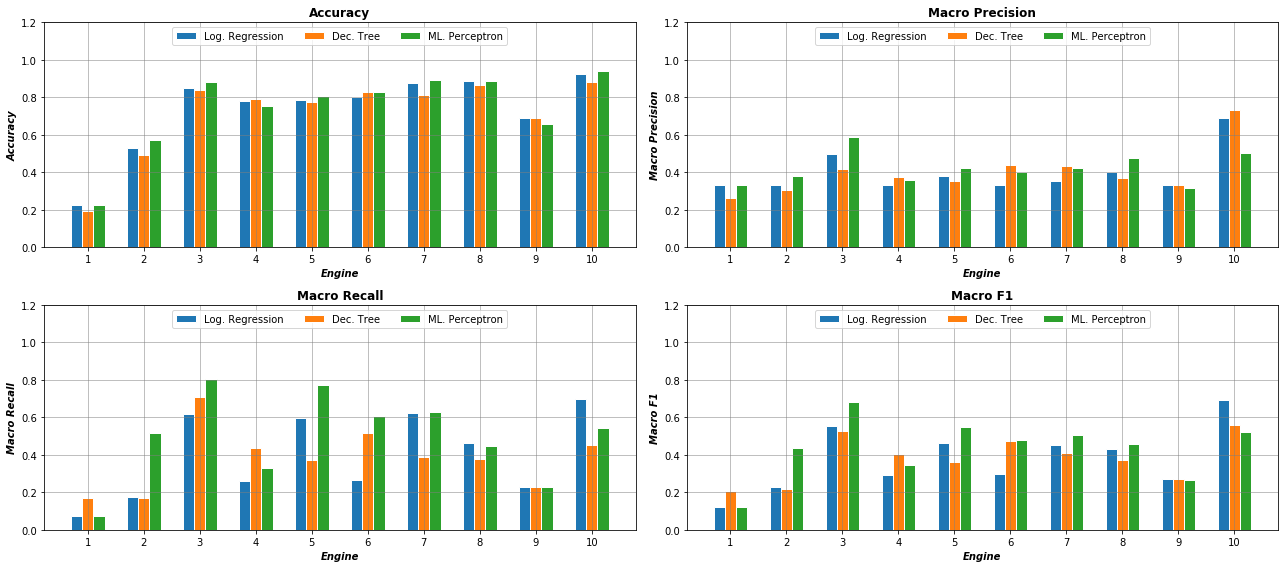

In [30]:
MCLR_eval = [accurany_list_mclr, mac_p_list_mclr, mac_r_list_mclr,  mac_F1_list_mclr]
MCDT_eval = [accurany_list_mcdt, mac_p_list_mcdt, mac_r_list_mcdt, mac_F1_list_mcdt]
MCPC_eval = [accurany_list_mcpc, mac_p_list_mcpc, mac_r_list_mcpc, mac_F1_list_mcpc]
metrics_names = ["Accuracy", "Macro Precision", "Macro Recall",  "Macro F1"]
Y_titles = metrics_names

def plot_eval_metrics_multi_classification(X, LR_eval, DT_eval, RF_eval, title, x_title, y_title, 
                                            rows, cols, figsize_H, figsize_V):
    
    '''
    this function plots an evaluation metric for a random set of engines
    
    INPUTS:
    @X: list of x axis ticks (representing engines)
    @Y: list of y axis ticks (representing eval matric)
    @start_col_idx: index of the first column to be plotted
    @rows: number of rows in the grid
    @cols: number of columns in the grid
    @figsize_H: figure size (horizontal)
    @figsize_V: figure size (vertical)
    '''
    # set list counter
    c = 0
    
    # set width of bar
    barWidth = 0.2
    
    # init plot
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(figsize_H, figsize_V))
    
    # set positions of categories columns on X axis 
    r2 = [str(x) for x in X]
    r1 = [x - barWidth for x in np.arange(len(X))]
    r3 = [x + barWidth for x in np.arange(len(X))] 

    # loop over featureas and add corresponded sub-plots
    for i in range(0,rows):
        for j in range(0,cols):
            
            #axes[i,j].scatter([str(x) for x in X], Y[c], color = 'r', label="Value")
            axes[i,j].bar(r1, LR_eval[c],  width=barWidth, edgecolor='white', label='Log. Regression')
            axes[i,j].bar(r2, DT_eval[c],  width=barWidth, edgecolor='white', label='Dec. Tree')
            axes[i,j].bar(r3, RF_eval[c],  width=barWidth, edgecolor='white', label='ML. Perceptron')
            axes[i,j].set_title(title[c], fontsize=12, fontweight='bold')  
            axes[i,j].set_xlabel(x_title, fontsize=10, fontweight='bold', style= "italic")
            axes[i,j].set_ylabel(y_title[c], fontsize=10, fontweight='bold', style= "italic")
            axes[i,j].set_ylim([0,1.2])    
            axes[i,j].grid(color='gray', linestyle='-', linewidth=.5)                                                        
            axes[i,j].legend(ncol=3, loc=9)
            
            c+= 1
    
    
    plt.tight_layout()
    
plot_eval_metrics_multi_classification(engines_list, MCLR_eval, MCDT_eval, MCPC_eval, 
                                        metrics_names, "Engine", Y_titles, 2, 2, 18, 8)